In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from numpy.linalg import solve
from scipy.sparse import spdiags
from scipy.linalg import lu,solve_triangular
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import gmres
import time
import imageio as io
from PIL import Image
from matplotlib.animation import FuncAnimation, MovieWriter, ImageMagickWriter
import random


In [56]:
m = 64    # N value in x and y directions
n = m * m  # total size of matrix

e0 = np.zeros((n, 1))  # vector of zeros
e1 = np.ones((n, 1))   # vector of ones
e2 = np.copy(e1)    # copy the one vector
e4 = np.copy(e0)    # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0  # overwrite every m^th value with zero
    e4[m*j-1] = 1  # overwirte every m^th value with one

# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Place diagonal elements
diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
             e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
             e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

A = spdiags(diagonals, offsets, n, n).toarray()
A = A / ((20/64)**2)
# Plot matrix structure
print(A.shape)
# Matrix B

# Grid size (8x8) = 64 elements in total
m = 64
n = m * m  # 64 elements

# Create vectors for the diagonals
main_diag = np.zeros(n)  # Main diagonal: 0 (no self-contribution)
upper_diag = np.ones(n)  # Upper diagonal: +1 (i, j+1)
lower_diag = np.ones(n)  # Lower diagonal: -1 (i, j-1)
upper2 = np.copy(upper_diag)
lower2 = np.copy(lower_diag)

for j in range(1, m+1):
    main_diag[m*j-1] = 0  # overwrite every m^th value with zero
    #e4[m*j-1] = 1  # overwirte every m^th value with one


# Place diagonal elements
diagonals = [lower2, -1*lower_diag, main_diag, upper_diag, -1*upper2]
offsets = [-(n-m), -m, 0, m, (n-m)]

B = spdiags(diagonals, offsets, n, n).toarray()
B = B / (40/64)
print(B.shape)

# Plot matrix structure

#Matrix C

# Grid size (8x8) = 64 elements in total
m = 64
n = m * m  # 64 elements

# Create vectors for the diagonals
main_diag = np.zeros(n)  # Main diagonal: 0 (no self-contribution)
upper_diag = np.ones(n)  # Upper diagonal: +1 (i, j+1)
lower_diag = np.ones(n)  # Lower diagonal: -1 (i, j-1)
upper2 = np.zeros(n)
lower2 = np.copy(main_diag)

for j in range(1, m+1):
    lower_diag[m*j-1] = 0  # overwrite every m^th value with zero
    upper2[m*j-1] = 1
   

#Shift to correct positions
lower2 = np.zeros_like(upper2)
lower2[1:n] = upper2[0:n-1]
lower2[0] = upper2[n-1]

upper_diag = np.zeros_like(lower_diag)
upper_diag[1:n] = lower_diag[0:n-1]
upper_diag[0] = lower_diag[n-1]

# Place diagonal elements
diagonals = [lower2, -1*lower_diag, main_diag, upper_diag, -1*upper2]
offsets = [-m+1, -1, 0, 1, m-1]

C = spdiags(diagonals, offsets, n, n).toarray()
C = C / (40/64)
print(C.shape)

(4096, 4096)
(4096, 4096)
(4096, 4096)


[[ 2.50656748e-46  3.54893701e-45  1.85736078e-44 ...  3.22138890e-36
   5.04776433e-36  7.58845332e-36]
 [ 1.17762859e-43  6.53684666e-43  2.62060667e-42 ...  1.66210463e-35
  -1.75956961e-35 -7.78389888e-35]
 [ 4.55107657e-41  1.93087628e-40  6.43663355e-40 ... -4.21370822e-33
  -8.66578083e-33 -1.18508019e-32]
 ...
 [ 1.96785570e-38  1.23636238e-37  5.46906656e-37 ...  1.39880811e-30
  -2.57184373e-29 -9.71737397e-29]
 [ 6.19028421e-41  5.34124949e-40  2.93882031e-39 ...  1.69834860e-31
  -1.63549354e-31 -1.23260430e-30]
 [ 1.60178709e-43  1.99879166e-42  1.41268009e-41 ...  6.29194477e-33
   6.32805583e-33 -4.94402809e-34]]


C:\Users\aarbe\AppData\Local\Temp\ipykernel_6752\872429191.py:63: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


Elapsed time: 60.98 seconds


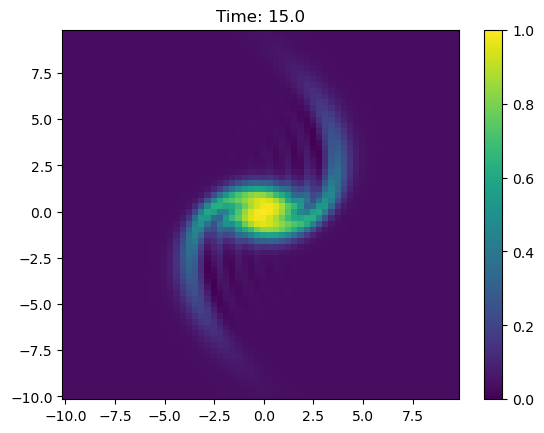

In [58]:
#PART A
# Define parameters
tspan = np.arange(0, 15.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

#A[0, 0] = 2 / ((20/64)**2)
#A[0, 0] = 2

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = (1 * np.exp(-X**2 - Y**2/20))  # Initialize as complex

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

start_time_fft = time.time()

# Define the ODE system
def spc_rhs(t, w, nx, ny, K, nu):
    wt = w.reshape((nx, ny))
    psit = ifft2(-1 /K *fft2(wt)).flatten()
    psi = psit
    rhs = nu * np.dot(A, w) + np.dot(B, w)*np.dot(C, psit) - np.dot(B, psit)*np.dot(C, w)
    return rhs

# Solve the ODE and plot the results
wt0 = w.flatten()
#wtsol = odeint(spc_rhs, wt0, tspan, args=(nx, ny, N, KX, KY, K, nu))
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, method='RK45', t_eval=tspan, args=(nx, ny, K, nu))
A1 = wtsol.y
A1_T = A1.T
print(A1)

# fig, ax = plt.subplots(figsize=(6,6))
# cax = ax.imshow(A1[:, 0].reshape((nx, ny)), extent = [-10, 10, -10, 10], cmap='jet')
# fig.colorbar(cax, ax=ax, label = 'Vorticity')
# ax.set_title('Vorticity Field')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# def update(frame):
#     ax.set_title(f'Vorticity Field at t = {frame * 0.5:.2f}')
#     cax.set_data(A1[:, frame].reshape((nx, ny)))
#     return cax,
# anim = FuncAnimation(fig, update, frames=A1.shape[1], blit=True)
# anim.save('./vorticity_evolution.gif', writer='imagemagick', fps=2)

frames = []
for j, t in enumerate(tspan):
    w = A1_T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    if j == 0:
        plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames]
images[0].save(
 'fft.gif',
 save_all=True,
 append_images=images[1:],
 duration=300,
 loop=0 # 0 means infinite loop
 )

# plt.tight_layout()
# plt.show()

end_time_fft = time.time()
elapsed_time_fft = end_time_fft - start_time_fft
print(f"Elapsed time: {elapsed_time_fft:.2f} seconds")

In [60]:
# PART Ba

A[0, 0] = 2 / ((20/64)**2)
w0 = (1 * np.exp(-X**2 - Y**2/20)).flatten() 

def spc_rhs(t, w, nu, A, B, C):
    psi = np.linalg.solve(A, w) 
    rhs = (nu*A.dot(w) - ((C.dot(w)) * (B.dot(psi))) + ((C.dot(psi))*(B.dot(w))))  
    return rhs

# Solve the ODE and plot the results
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], w0, method='RK45', t_eval=tspan, args=(nu, A, B, C))
A2 = wtsol.y

print(A2)

frames_solve = []
for j, t in enumerate(tspan):
    w = A2.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    if j==0:
        plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_solve.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_solve]
images[0].save(
 'solve.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
)

KeyboardInterrupt: 

[[ 2.50656748e-46 -1.78630705e-36  1.02614869e-36 ...  2.51743836e-09
   2.30077532e-09  3.30131377e-09]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ...  1.09470781e-03
   1.25756190e-03 -2.68421203e-03]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -1.74117294e-06
   1.97853526e-06 -1.22647683e-07]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  1.64921898e-05
  -1.78156652e-05  9.38738027e-07]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  1.01798557e-04
   1.16947948e-04 -2.49577888e-04]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ... -1.29451196e-03
   1.39942687e-03 -7.37936381e-05]]


C:\Users\aarbe\AppData\Local\Temp\ipykernel_6752\2608395852.py:26: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


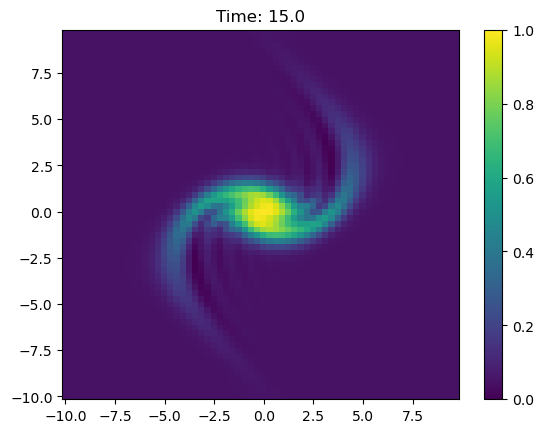

In [24]:
# PART Bb

w = (1 * np.exp(-X**2 - Y**2/20)).flatten()
P, L, U = lu(A)

def spc_rhs(t, w, nu, A, B, C):
    P_psi = np.dot(P, w)
    y = solve_triangular(L, P_psi, lower=True)
    psi = solve_triangular(U, y)

    rhs = (nu*A.dot(w) - ((C.dot(w))* (B.dot(psi))) + ((C.dot(psi))*(B.dot(w))))
    return rhs

# Solve the ODE and plot the results
wt0= w
#wtsol = odeint(spc_rhs, wt0, tspan, args=(nx, ny, N, KX, KY, K, nu))
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, method='RK45', t_eval=tspan, args=(nu, A, B, C))
A3 = wtsol.y

print(A3)

frames_LU = []
for j, t in enumerate(tspan):
    w = A3.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    if j==0:
        plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_LU.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_LU]
images[0].save(
 'LU.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
)

In [26]:
# PART Bc
w = (1 * np.exp(-X**2 - Y**2/20)).flatten()

def spc_rhs(t, w, nu, A, B, C):
    psi, exit_code = bicgstab(A, w, rtol=1e-3)
    #print(exit_code)

    rhs = nu*A.dot(w) - (C.dot(w)) * (B.dot(psi)) + (C.dot(psi))*(B.dot(w))
    return rhs

# Solve the ODE and plot the results
wt0= w
#wtsol = odeint(spc_rhs, wt0, tspan, args=(nx, ny, N, KX, KY, K, nu))
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, method='RK45', t_eval=tspan, args=(nu, A, B, C))
A4 = wtsol.y


frames_BIC = []
for j, t in enumerate(tspan):
    w = A4.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    if j==0:
        plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_BIC.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_BIC]
images[0].save(
 'BIC.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
 )

KeyboardInterrupt: 

In [28]:
# PART Bd
w = (1 * np.exp(-X**2 - Y**2/20)).flatten()

def spc_rhs(t, w, nu, A, B, C):
    psi = gmres(A, w)[0]

    rhs = (nu*A.dot(w) - ((C.dot(w))* (B.dot(psi))) + ((C.dot(psi))*(B.dot(w))))
    return rhs

# Solve the ODE and plot the results
wt0= w
#wtsol = odeint(spc_rhs, wt0, tspan, args=(nx, ny, N, KX, KY, K, nu))
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt0, method='RK45', t_eval=tspan, args=(nu, A, B, C))
A5 = wtsol.y


frames_gmres = []
for j, t in enumerate(tspan):
    w = A5.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    if j==0:
        plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_gmres.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_gmres]
images[0].save(
 'gmres.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
 )

KeyboardInterrupt: 

C:\Users\aarbe\AppData\Local\Temp\ipykernel_6752\2327510949.py:28: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


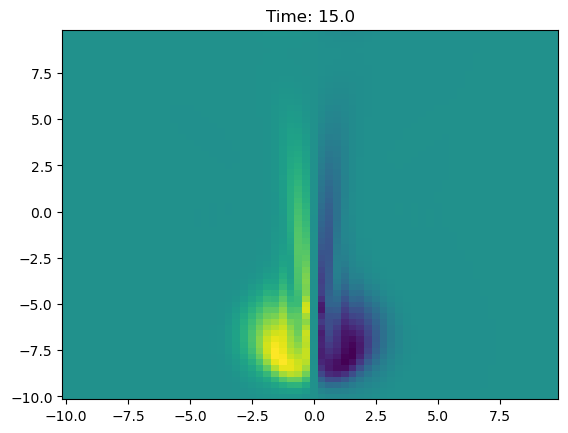

In [30]:
#Part Ca
w0_ca1 = (1 * np.exp(-(X+1)**2 - Y**2/20))
w0_ca2 = (-1 * np.exp(-(X-1)**2 - Y**2/20))
combo_ca2 = w0_ca1+w0_ca2

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def spc_rhs(t, w, nx, ny, K, nu):
    wt = fft2(w.reshape((nx, ny)))
    psit = ifft2(-1 /K *(wt))
    psi = psit
    rhs = nu * np.dot(A, w) + np.dot(B, w)*np.dot(C, psi.flatten()) - np.dot(B, psi.flatten())*np.dot(C, w)
    return rhs

w0 = combo_ca2.flatten()
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], w0, method='RK45', t_eval=tspan, args=(nx, ny, K, nu))
A6 = wtsol.y

frames_Ca = []
for j, t in enumerate(tspan):
    w = A6.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    # if j==0:
    #     plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_Ca.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_Ca]
images[0].save(
 'Ca.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
 )

C:\Users\aarbe\AppData\Local\Temp\ipykernel_6752\735790210.py:28: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


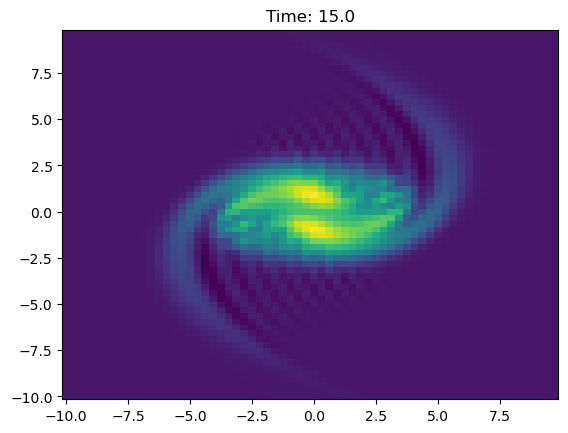

In [33]:
#Part Cb
w0_cb1 = (1 * np.exp(-(X+1)**2 - Y**2/20))
w0_cb2 = (1 * np.exp(-(X-1)**2 - Y**2/20))
combo_cb2 = w0_cb1+w0_cb2

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def spc_rhs(t, w, nx, ny, K, nu):
    wt = fft2(w.reshape((nx, ny)))
    psit = ifft2(-1 /K *(wt))
    psi = psit
    rhs = nu * np.dot(A, w) + np.dot(B, w)*np.dot(C, psi.flatten()) - np.dot(B, psi.flatten())*np.dot(C, w)
    return rhs

w0 = combo_cb2.flatten()
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], w0, method='RK45', t_eval=tspan, args=(nx, ny, K, nu))
A7 = wtsol.y

frames_Cb = []
for j, t in enumerate(tspan):
    w = A7.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    # if j==0:
    #     plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_Cb.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_Cb]
images[0].save(
 'Cb.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
 )

C:\Users\aarbe\AppData\Local\Temp\ipykernel_6752\1051661734.py:30: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


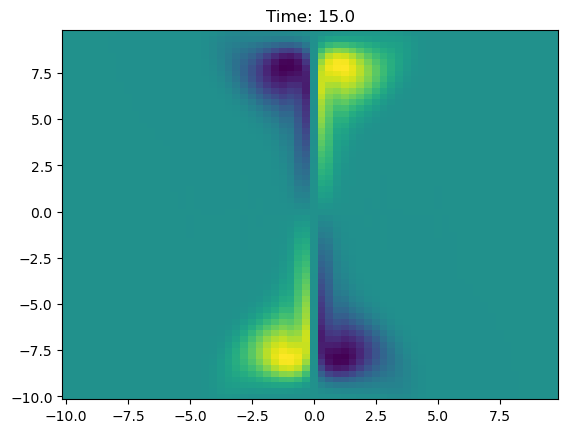

In [41]:
#Part Cc
w0_cc1 = (-1 * np.exp(-(X+1)**2 - (Y-2)**2/20))
w0_cc2 = (1 * np.exp(-(X-1)**2 - (Y-2)**2/20))
w0_cc3 = (1 * np.exp(-(X+1)**2 - (Y+2)**2/20))
w0_cc4 = (-1 * np.exp(-(X-1)**2 - (Y+2)**2/20))
combo_cc = w0_cc1+w0_cc2+w0_cc3+w0_cc4

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def spc_rhs(t, w, nx, ny, K, nu):
    wt = fft2(w.reshape((nx, ny)))
    psit = ifft2(-1 /K *(wt))
    psi = psit
    rhs = nu * np.dot(A, w) + np.dot(B, w)*np.dot(C, psi.flatten()) - np.dot(B, psi.flatten())*np.dot(C, w)
    return rhs

w0 = combo_cc.flatten()
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], w0, method='RK45', t_eval=tspan, args=(nx, ny, K, nu))
A8 = wtsol.y

frames_Cc = []
for j, t in enumerate(tspan):
    w = A8.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    # if j==0:
    #     plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_Cc.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_Cc]
images[0].save(
 'Cc.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
 )

C:\Users\aarbe\AppData\Local\Temp\ipykernel_6752\2471295060.py:39: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


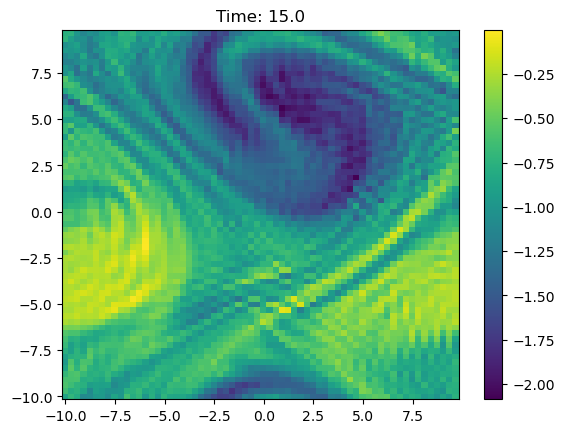

In [50]:
#PART Cd
wombo_combo = 0
for i in range(11):
    x_pos = random.uniform(-10, 10)
    y_pos = random.uniform(-10, 10)
    strength = random.uniform(1, 5)
    ellipticity_x = random.uniform(1, 20)
    ellipticity_y = random.uniform(1, 20)
    wombo_combo += -1**i * np.exp((-(X+x_pos)**2/ellipticity_x) - ((Y+y_pos)**2/ellipticity_y))



# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

# Define the ODE system
def spc_rhs(t, w, nx, ny, K, nu):
    wt = fft2(w.reshape((nx, ny)))
    psit = ifft2(-1 /K *(wt))
    psi = psit
    rhs = nu * np.dot(A, w) + np.dot(B, w)*np.dot(C, psi.flatten()) - np.dot(B, psi.flatten())*np.dot(C, w)
    return rhs

w0 = wombo_combo.flatten()
wtsol = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], w0, method='RK45', t_eval=tspan, args=(nx, ny, K, nu))
#wtsol2 = solve_ivp(spc_rhs, [tspan[0], tspan[-1]], wt02, method='RK45', t_eval=tspan, args=(nx, ny, K, nu))
A9 = wtsol.y
#A2 = wtsol2.y.T

frames_combo = []
for j, t in enumerate(tspan):
    w = A9.T[j,:N].reshape((nx, ny))
    #plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    if j==0:
        plt.colorbar()
    plt.savefig(f'frame{j}.png')
    #frames.append(io.imread(f'frame{j}.png'))
    frames_combo.append(f'frame{j}.png')
    
images = [Image.open(curr_frame) for curr_frame in frames_combo]
images[0].save(
 'combo.gif',
 save_all=True,
 append_images=images[1:],
 duration=200,
 loop=0 # 0 means infinite loop
 )